In [1]:
# Construction of dataset

import os, itertools, time, pickle, sys, glob, requests
import subprocess
from xml.dom import minidom
from collections import Counter, OrderedDict
from operator import itemgetter
from nltk.corpus import wordnet
import tensorflow as tf
import tensorflow_hub as hub
from scipy import spatial
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import numpy as np
import scipy.sparse as sp
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from math import ceil, exp
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import networkx as nx
import matplotlib.pyplot as plt
from orderedset import OrderedSet
from copy import deepcopy

%matplotlib inline  

In [2]:
flatten = lambda l: [item for sublist in l for item in sublist]

class Ontology():
    def __init__(self, ontology):
        self.acceptable_props = ["part_of", "is_a", "has_part"]
        self.ontology = ontology
        self.ontology_obj = minidom.parse(ontology)
        self.root = self.ontology_obj.documentElement
        self.construct_mapping_dict()
        
        self.parents_dict = {}
        self.subclasses = self.parse_subclasses()
        self.object_properties = self.parse_object_properties()
        self.data_properties = self.parse_data_properties()
        self.triples = self.parse_triples()
        self.classes = self.parse_classes()               
    
    def construct_mapping_dict(self):
        self.mapping_dict = {self.extract_ID(el, False): self.get_child_node(el, "rdfs:label")[0].firstChild.nodeValue for el in self.root.getElementsByTagName("owl:Class") if self.get_child_node(el, "rdfs:label")}
        self.mapping_dict_inv = {self.mapping_dict[key]: key for key in self.mapping_dict}
        return
        
    def get_child_node(self, element, tag):
        return [e for e in element._get_childNodes() if type(e)==minidom.Element and e._get_tagName() == tag]
        
    def has_attribute_value(self, element, attribute, value):
        return True if element.getAttribute(attribute).split("#")[-1] == value else False
    
    def get_subclass_triples(self):
        subclasses = self.get_subclasses()
        self.parents_dict = {}
        for (a,b,c,d) in subclasses:
            if c == "subclass_of" and a!="Thing" and b!="Thing":
                if b not in self.parents_dict:
                    self.parents_dict[b] = [a]
                else:
                    self.parents_dict[b].append(a)
        return [(b,a,c,d) for (a,b,c,d) in subclasses]
    
    def parse_triples(self, union_flag=0, subclass_of=True):
        obj_props = [(prop, "Object Property") for prop in self.object_properties]
        data_props = [(prop, "Datatype Property") for prop in self.data_properties]
        props = obj_props + data_props
        all_triples = []
        for prop, prop_type in props:
            domain_children = self.get_child_node(prop, "rdfs:domain")
            range_children = self.get_child_node(prop, "rdfs:range")
            domain_prop = self.filter_null([self.extract_ID(el) for el in domain_children])
            range_prop = self.filter_null([self.extract_ID(el) for el in range_children])
            if not domain_children or not range_children:
                continue
            if not domain_prop:
                domain_prop = self.filter_null([self.extract_ID(el) for el in domain_children[0].getElementsByTagName("owl:Class")])
            if not range_prop:
                range_prop = self.filter_null([self.extract_ID(el) for el in range_children[0].getElementsByTagName("owl:Class")])
            if domain_prop and range_prop:
                if union_flag == 0:
                    all_triples.extend([(el[0], el[1], self.extract_ID(prop), prop_type) for el in list(itertools.product(domain_prop, range_prop))])
                else:
                    all_triples.append(("###".join(domain_prop), "###".join(range_prop), self.extract_ID(prop), prop_type))
        if subclass_of:
            all_triples.extend(self.get_subclass_triples())
        
        return [elem for elem in list(set(all_triples)) if elem[-1] == "Subclass" or elem[-2] in self.acceptable_props]
    
    def get_triples(self, union_flag=0, subclass_of=True):
        return self.parse_triples(union_flag, subclass_of)

    def parse_subclasses(self, union_flag=0):
        subclasses = self.root.getElementsByTagName("rdfs:subClassOf")
        subclass_pairs = []
        for el in subclasses:
            inline_subclasses = self.extract_ID(el)
            if inline_subclasses:
                subclass_pairs.append((el, el.parentNode, "subclass_of", "Subclass"))
            else:
                level1_class = self.get_child_node(el, "owl:Class")
                if not level1_class:
                    restriction = el.getElementsByTagName("owl:Restriction")
                    if not restriction:
                        continue
                    prop = self.get_child_node(restriction[0], "owl:onProperty")
                    some_vals = self.get_child_node(restriction[0], "owl:someValuesFrom")
                    
                    if not prop or not some_vals:
                        continue
#                     print(self.extract_ID(el), "**", self.extract_ID(some_vals[0]), "**", self.extract_ID(prop[0]))
                    try:
                        if self.extract_ID(prop[0]) and self.extract_ID(some_vals[0]):
                            subclass_pairs.append((el.parentNode, some_vals[0], self.extract_ID(prop[0]), "Object Property"))
                        elif self.extract_ID(prop[0]) and not self.extract_ID(some_vals[0]):
                            class_vals = self.get_child_node(some_vals[0], "owl:Class")
                            subclass_pairs.append((el.parentNode, class_vals[0], self.extract_ID(prop[0]), "Object Property"))
                        elif not self.extract_ID(prop[0]) and self.extract_ID(some_vals[0]):
                            prop_vals = self.get_child_node(prop[0], "owl:ObjectProperty")
                            subclass_pairs.append((el.parentNode, some_vals[0], self.extract_ID(prop_vals[0]), "Object Property"))
                        else:
                            prop_vals = self.get_child_node(prop[0], "owl:ObjectProperty")
                            class_vals = self.get_child_node(some_vals[0], "owl:Class")
                            subclass_pairs.append((el.parentNode, class_vals[0], self.extract_ID(prop_vals[0]), "Object Property"))
                    except:
                        try:
                            if not self.extract_ID(prop[0]) and self.extract_ID(some_vals[0]):
                                prop_vals = self.get_child_node(prop[0], "owl:DatatypeProperty")
                                subclass_pairs.append((el.parentNode, some_vals[0], self.extract_ID(prop_vals[0]), "Datatype Property"))
                            elif not self.extract_ID(prop[0]) and not self.extract_ID(some_vals[0]):
                                prop_vals = self.get_child_node(prop[0], "owl:DatatypeProperty")
                                class_vals = self.get_child_node(some_vals[0], "owl:Class")
                                subclass_pairs.append((el.parentNode, class_vals[0], self.extract_ID(prop_vals[0]), "Datatype Property"))
                        except Exception as e:
                            print (e)
                            continue
                else:
                    if self.extract_ID(level1_class[0]):
                        subclass_pairs.append((level1_class[0], el.parentNode, "subclass_of", "Subclass"))
                    else:
#                         level2classes = level1_class[0].getElementsByTagName("owl:Class")
#                         subclass_pairs.extend([(elem, el.parentNode, "subclass_of", "Subclass") for elem in level2classes if self.extract_ID(elem)])
                        continue
        return subclass_pairs
        
    def get_subclasses(self):
        subclasses = [(self.extract_ID(a), self.extract_ID(b), c, d) for (a,b,c,d) in self.subclasses]
        return [el for el in subclasses if el[0] and el[1] and el[2] and el[0]!="Thing" and el[1]!="Thing"]
    
    def filter_null(self, data):
        return [el for el in data if el]
    
    def extract_ID(self, element, check_coded = True):
        element_id = element.getAttribute("rdf:ID") or element.getAttribute("rdf:resource") or element.getAttribute("rdf:about")
        element_id = element_id.split("#")[-1]
        if len(list(filter(str.isdigit, element_id))) >= 3 and "_" in element_id and check_coded:
            return self.mapping_dict[element_id]
        return element_id.replace("UNDEFINED_", "").replace("DO_", "")
    
    def parse_classes(self):
        class_elems = [self.extract_ID(el) for el in self.root.getElementsByTagName("owl:Class")]
        subclass_classes = list(set(flatten([el[:-1] for el in self.triples])))
        return list(set(self.filter_null(class_elems + subclass_classes)))
    
    def get_classes(self):
        return self.classes
    
    def get_entities(self):
        entities = [self.extract_ID(el) for el in self.root.getElementsByTagName("owl:Class")]
        return list(set(self.filter_null(entities)))

    def parse_data_properties(self):
        data_properties = [el for el in self.get_child_node(self.root, 'owl:DatatypeProperty')]
        fn_data_properties = [el for el in self.get_child_node(self.root, 'owl:FunctionalProperty') if el]
        fn_data_properties = [el for el in fn_data_properties if type(el)==minidom.Element and 
            [el for el in self.get_child_node(el, "rdf:type") if 
             self.has_attribute_value(el, "rdf:resource", "DatatypeProperty")]]
        inv_fn_data_properties = [el for el in self.get_child_node(self.root, 'owl:InverseFunctionalProperty') if el]
        inv_fn_data_properties = [el for el in inv_fn_data_properties if type(el)==minidom.Element and 
            [el for el in self.get_child_node(el, "rdf:type") if 
             self.has_attribute_value(el, "rdf:resource", "DatatypeProperty")]]
        return data_properties + fn_data_properties + inv_fn_data_properties
        
    def parse_object_properties(self):
        obj_properties = [el for el in self.get_child_node(self.root, 'owl:ObjectProperty')]
        fn_obj_properties = [el for el in self.get_child_node(self.root, 'owl:FunctionalProperty') if el]
        fn_obj_properties = [el for el in fn_obj_properties if type(el)==minidom.Element and 
            [el for el in self.get_child_node(el, "rdf:type") if 
             self.has_attribute_value(el, "rdf:resource", "ObjectProperty")]]
        inv_fn_obj_properties = [el for el in self.get_child_node(self.root, 'owl:InverseFunctionalProperty') if el]
        inv_fn_obj_properties = [el for el in inv_fn_obj_properties if type(el)==minidom.Element and 
            [el for el in self.get_child_node(el, "rdf:type") if 
             self.has_attribute_value(el, "rdf:resource", "ObjectProperty")]]
        return obj_properties + fn_obj_properties + inv_fn_obj_properties
    
    def get_object_properties(self):
        obj_props = [self.extract_ID(el) for el in self.object_properties]
        return list(set(self.filter_null(obj_props)))
    
    def get_data_properties(self):
        data_props = [self.extract_ID(el) for el in self.data_properties]
        return list(set(self.filter_null(data_props)))


In [6]:
alignment_folder = "../Anatomy/Alignments"

# Load reference alignments 
def load_alignments(folder):
    alignments = []
    for f in os.listdir(folder):
        doc = minidom.parse(folder + f)
        ls = list(zip(doc.getElementsByTagName('entity1'), doc.getElementsByTagName('entity2')))
        alignments.extend([(a.getAttribute('rdf:resource'), b.getAttribute('rdf:resource')) for (a,b) in ls])
    return alignments

# Extracting USE embeddings

def extractUSEEmbeddings(words):
    model = hub.load("https://tfhub.dev/google/universal-sentence-encoder-large/5?tf-hub-format=compressed")
    embeds = model(words)
    return embeds.numpy()

def cos_sim(a,b):
    return 1 - spatial.distance.cosine(a, b)


ra_anatomy_coded = load_alignments(alignment_folder)
gt_mappings = []
ont1 = Ontology("../Anatomy/Ontologies/mouse.owl")
ont2 = Ontology("../Anatomy/Ontologies/human.owl")
for elem in ra_anatomy_coded:
    pre1, pre2 = elem[0].split("#")[0].split(".")[0].split("/")[-1], elem[1].split("#")[0].split(".")[0].split("/")[-1]
    elem1, elem2 = elem[0].split("#")[-1], elem[1].split("#")[-1]
    gt_mappings.append(( pre1 + "#" + ont1.mapping_dict[elem1], pre2 + "#" + ont2.mapping_dict[elem2]))



# ontologies_in_alignment = pickle.load(open("../data_generic.pkl", "rb"))[-1][:-1]
ontologies_in_alignment = [["../Anatomy/Ontologies/mouse.owl", "../Anatomy/Ontologies/human.owl"]]


FileNotFoundError: [Errno 2] No such file or directory: '../Anatomy/Alignmentsreference.rdf'

In [7]:
# Combinatorial mapping generation
all_mappings = []
for l in ontologies_in_alignment:
    ont1 = Ontology(l[0])
    ont2 = Ontology(l[1])
    
    ent1 = ont1.get_entities()
    ent2 = ont2.get_entities()
    
    mappings = list(itertools.product(ent1, ent2))

    
    all_mappings.extend([(l[0].split("/")[-1].split(".")[0] + "#" + el[0], l[1].split("/")[-1].split(".")[0] + "#" + el[1]) for el in mappings])
    

data = {mapping: False for mapping in all_mappings}
for mapping in set(gt_mappings):
    data[mapping] = True

In [8]:
# Abbrevation resolution preprocessing

abbreviations_dict = {}
final_dict = {}
all_mappings_new = []
for mapping in all_mappings:
    mapping = tuple([el.split("#")[1].replace("_", " ") for el in mapping])
    mapping_new = []
    for elem in mapping:
        word_replace = []
        digit = ""
        for word in elem.split():
            if re.search("\d", word):
                word_sub = re.sub("\d", "", word)
                digit = re.search("\d", word).group()
            else:
                word_sub = word
            word_replace.append(word_sub)
        if digit:
            word_replace.append(digit)
        word_replace = [el for el in word_replace if el]
        mapping_new.append(" ".join(word_replace))
    all_mappings_new.append(mapping_new)
    mapping = tuple(mapping_new)
    is_abb = re.search("[A-Z]([A-Z]+| )", mapping[0])
    if is_abb:
        abbreviation = "".join([el[0].upper() for el in mapping[1].split(" ")])
        if is_abb.group().strip() in abbreviation:
            
            start = abbreviation.find(is_abb.group().strip())
            end = start + len(is_abb.group().strip())
            fullform = " ".join(mapping[1].split(" ")[start:end])
            
            rest_first = " ".join([el for el in mapping[0].replace(is_abb.group(), "").split(" ") if el]).lower()
            rest_second = " ".join(mapping[1].split(" ")[:start] + mapping[1].split(" ")[end:])
            if is_abb.group() not in final_dict:
                final_dict[is_abb.group()] = [(fullform, rest_first, rest_second)]
            else:
                final_dict[is_abb.group()].append((fullform, rest_first, rest_second))

    is_abb = re.search("[A-Z]([A-Z]+| )", mapping[1])
    if is_abb:
        abbreviation = "".join([el[0].upper() for el in mapping[0].split(" ")])
        
        if is_abb.group().strip() in abbreviation:
            start = abbreviation.find(is_abb.group().strip())
            end = start + len(is_abb.group().strip())
            fullform = " ".join(mapping[0].split(" ")[start:end])

            rest_first = " ".join([el for el in mapping[1].replace(is_abb.group(), "").split(" ") if el]).lower()
            rest_second = " ".join(mapping[0].split(" ")[:start] + mapping[0].split(" ")[end:])
            if is_abb.group() not in final_dict:
                final_dict[is_abb.group()] = [(fullform, rest_first, rest_second)]
            else:
                final_dict[is_abb.group()].append((fullform, rest_first, rest_second))

keys = [el for el in list(set(flatten([flatten([tup[1:] for tup in final_dict[key]]) for key in final_dict]))) if el]
abb_embeds = dict(zip(keys, extractUSEEmbeddings(keys)))

scored_dict = {}
for abbr in final_dict:
    sim_list = [(tup[0], tup[1], tup[2], cos_sim(abb_embeds[tup[1]], abb_embeds[tup[2]])) if tup[1] and tup[2]
                else (tup[0], tup[1], tup[2], 0) for tup in final_dict[abbr]]
    scored_dict[abbr] = sorted(list(set(sim_list)), key=lambda x:x[-1], reverse=True)

resolved_dict = {key: scored_dict[key][0] for key in scored_dict}
filtered_dict = {key: " ".join(resolved_dict[key][0].split("_")) for key in resolved_dict if resolved_dict[key][-1] > 0.9}



In [9]:

def camel_case_split(identifier):
    matches = re.finditer('.+?(?:(?<=[a-z])(?=[A-Z])|(?<=[A-Z])(?=[A-Z][a-z])|$)', identifier)
    return [m.group(0) for m in matches]

def parse(word):
    return flatten([el.split("_") for el in camel_case_split(word)])
    

extracted_elems = []

for ont_name in list(set(flatten(ontologies_in_alignment))):
    
    ont = Ontology(ont_name)
    entities = ont.get_entities()
    entities += list(set(flatten([(a,b) for (a,b,c,d) in ont.get_triples()])))
    extracted_elems.extend([ont_name.split("/")[-1].split(".")[0] + "#" + elem for elem in entities])

extracted_elems = list(set(extracted_elems))
inp_anatomy = [" ".join(parse(word.split("#")[1])) for word in extracted_elems]

roman_regex = "^M{0,3}(CM|CD|D?C{0,3})(XC|XL|L?X{0,3})(IX|IV|V?I{0,3})$"
inp_anatomy = [" ".join([word.replace("/", " or ").replace("_", " ") for word in elem.split()]) for elem in inp_anatomy]
inp_numbered = []
for elem in inp_anatomy:
    word_replace = []
    digit = ""
    for word in elem.split():
        if re.search("\d", word):
            word_sub = re.sub("\d", "", word)
            digit = re.search("\d", word).group()
        else:
            word_sub = word
        word_replace.append(word_sub)
    if digit:
        word_replace.append(digit)
    inp_numbered.append(" ".join(word_replace))

inp_resolved = []
for concept in inp_numbered:
    for key in filtered_dict:
        if key in concept:
            print ("Replacing {} with {} in {}".format(key, filtered_dict[key], concept))
        concept = concept.replace(key, filtered_dict[key])
    final_list = []
    # Lowering case except in abbreviations
    for word in concept.split(" "):
        if not re.search("[A-Z][A-Z]+", word):
            final_list.append(word.lower())
        else:
            final_list.append(word)
    
    concept = " ".join(final_list)
    
    inp_resolved.append(concept)


print ("Total number of extracted unique classes and properties from entire RA set: ", len(extracted_elems))

extracted_elems = ["<UNK>"] + extracted_elems

embeds = np.array(extractUSEEmbeddings(inp_resolved))
embeds = np.array([np.zeros(embeds.shape[1],)] + list(embeds))
# embeds = np.array([np.zeros(512,)] + list(extractUSEEmbeddings(inp_spellchecked)))
embeddings = dict(zip(extracted_elems, embeds))

emb_vals = list(embeddings.values())
emb_indexer = {key: i for i, key in enumerate(list(embeddings.keys()))}
emb_indexer_inv = {i: key for i, key in enumerate(list(embeddings.keys()))}


Replacing T  with thoracic in T Vertebra 1
Replacing C  with cervical in C Vertebra 2
Replacing T  with thoracic in T Vertebra 4
Replacing T  with thoracic in T Vertebra 1
Replacing L  with lumbar in L Vertebra 4
Replacing T  with thoracic in T Vertebra 5
Replacing T  with thoracic in T Vertebra 9
Replacing T  with thoracic in T Vertebra 1
Replacing C  with cervical in C Vertebra 7
Replacing C  with cervical in C Vertebra 5
Replacing S  with sacral in S Vertebra 2
Replacing L  with lumbar in L Vertebra 5
Replacing C  with cervical in C Vertebra 4
Replacing S  with sacral in S Vertebra 1
Replacing T  with thoracic in T Vertebra 3
Replacing C  with cervical in C Vertebra 6
Replacing S  with sacral in S Vertebra 3
Replacing L  with lumbar in L Vertebra 3
Replacing C  with cervical in C Vertebra 3
Replacing C  with cervical in C Vertebra 1
Replacing T  with thoracic in T Vertebra 6
Replacing T  with thoracic in T Vertebra 1
Replacing T  with thoracic in T Vertebra 2
Replacing S  with sacra

In [5]:
aml_data = data

In [19]:
ontologies_in_alignment = [["../Anatomy/Ontologies/mouse.owl", "../Anatomy/Ontologies/human.owl"]]
rootpath_dict_new = {}
limit = 3
def path_to_root(elem, ont_mappings, curr = [], rootpath=[]):
    sys.stdout.flush()
    curr.append(elem)
    if elem not in ont_mappings or not ont_mappings[elem]:
        rootpath.append(curr)
        return
    for node in ont_mappings[elem]:
        curr_orig = deepcopy(curr)
        _ = path_to_root(node, ont_mappings, curr, rootpath)
        curr = curr_orig
    return rootpath

def get_one_hop_neighbours(ont, K=1):
    global rootpath_dict_new
    ont_obj = Ontology(ont)
    triples = ont_obj.get_triples()
    entities = [(a,b) for (a,b,c,d) in triples]
    neighbours_dict = {elem: [[] for i in range(4)] for elem in list(set(flatten(entities)))}
    print (ont)
    for (e1, e2, p, d) in triples:
        if e1==e2:
            continue
        if d == "Object Property":
            neighbours_dict[e1][2].append([e2])
            neighbours_dict[e2][2].append([e1])
        elif d == "Datatype Property":
            neighbours_dict[e1][3].append([e2])
            neighbours_dict[e2][3].append([e1])
        elif d == "Subclass":
            neighbours_dict[e2][1].append([e1])
        else:
            print ("Error wrong value of d: ", d)
    
    rootpath_dict = ont_obj.parents_dict
    rootpath_dict_new = {}
    for elem in rootpath_dict:
#         print ("Done for ", elem)
        rootpath_dict_new[elem] = path_to_root(elem, rootpath_dict, [], [])
    ont = ont.split("/")[-1].split(".")[0]

    
    for entity in neighbours_dict:
        if entity in rootpath_dict_new and len(rootpath_dict_new[entity]) > 0:
            neighbours_dict[entity][0].extend(rootpath_dict_new[entity])
        else:
            continue
    
#     prop_triples = ont_obj.get_triples(subclass_of=False)
#     neighbours_dict_props = {c: [c] for a,b,c in prop_triples}
#     for e1, e2, p in prop_triples:
#         neighbours_dict_props[p].extend([e1, e2])

    #neighbours_dict = {**neighbours_dict, **neighbours_dict_props}
    
    # for elem in ont_obj.get_entities() + ont_obj.get_object_properties() + ont_obj.get_data_properties():
    #     if elem not in neighbours_dict:
    #         neighbours_dict[elem] = [elem]

#     neighbours_dict = {elem: [key[:1] + sorted(list(set(key[1:]))) for key in neighbours_dict[elem]]
#                        for elem in neighbours_dict}
#     neighbours_dict = {el: neighbours_dict[el][:23] for el in neighbours_dict if len( neighbours_dict[el]) > 2}
#     ont = ont.split("/")[-1].split(".")[0]
    neighbours_dict = {ont + "#" + el: [OrderedSet([tuple([ont + "#" + node for node in path]) for path in nbr_type])
                                        for nbr_type in neighbours_dict[el]] 
                       for el in neighbours_dict}
    neighbours_dict = {el: [[list(path) for path in nbr_type] for nbr_type in neighbours_dict[el]]
                       for el in neighbours_dict}
    return neighbours_dict

neighbours_dicts = {}
for ont in list(set(flatten(ontologies_in_alignment))):
    neighbours_dicts = {**neighbours_dicts, **get_one_hop_neighbours(ont)}
max_types = np.max([len([nbr_type for nbr_type in elem if nbr_type]) for elem in neighbours_dicts.values()])
max_paths = np.max([[len(nbr_type) for nbr_type in elem] for elem in neighbours_dicts.values()])
max_pathlen = np.max(flatten([flatten([[len(path) for path in nbr_type] for nbr_type in elem]) for elem in neighbours_dicts.values()]), axis=0)
# neighbours_dicts_lenpadded = {elem: [[path + ["<UNK>" for i in range(max_pathlen -len(path))] for path in nbr_type]
#                                 for nbr_type in neighbours_dicts[elem]] for elem in neighbours_dicts}
# neighbours_dicts_pathpadded = {elem: [nbr_type + [["<UNK>" for j in range(max_pathlen)] for i in range(max_paths - len(nbr_type))]
#                                 for k,nbr_type in enumerate(neighbours_dicts_lenpadded[elem])] for elem in neighbours_dicts_lenpadded}
# neighbours_dicts_pathpadded = {elem: np.array(neighbours_dicts_pathpadded[elem]) for elem in neighbours_dicts_pathpadded}

data_items = data.items()
data_shuffled_t = [elem for elem in data_items if elem[1]]
data_shuffled_f = [elem for elem in data_items if not elem[1]]
np.random.shuffle(data_shuffled_f)
data_shuffled_f = data_shuffled_f[:150000-len(data_shuffled_t)]
data = data_shuffled_t + data_shuffled_f
data = OrderedDict(data)

aml_data_items = aml_data.items()
aml_data_shuffled_t = [elem for elem in aml_data_items if elem[1]]
aml_data_shuffled_f = [elem for elem in aml_data_items if not elem[1]]
np.random.shuffle(aml_data_shuffled_f)
aml_data_shuffled_f = aml_data_shuffled_f[:150000-len(aml_data_shuffled_t)]
aml_data = aml_data_shuffled_t + aml_data_shuffled_f
aml_data = OrderedDict(aml_data)

ontologies_in_alignment_rev = [[el.split("/")[-1].split(".")[0] for el in ont] for ont in ontologies_in_alignment]
# f = open("Input/data_anatomy_oaei.pkl", "wb")
# pickle.dump([data, aml_data, emb_indexer, emb_indexer_inv, emb_vals, gt_mappings, neighbours_dicts, ontologies_in_alignment_rev, max_types, max_paths, max_pathlen], f)


../Anatomy/Ontologies/human.owl
../Anatomy/Ontologies/mouse.owl


In [40]:
from collections import Sequence
def embedify(seq, emb_indexer):
    for item in seq:
        if isinstance(item, list):
            yield list(embedify(item, emb_indexer))
        else:
            yield emb_indexer[item]

def generate_data(elem_tuple):
    return list(embedify([neighbours_dicts[elem] for elem in elem_tuple], emb_indexer))

generate_data(('human#Intercostal_Muscle', 'human#Circular_Ligament_of_the_Tooth'))

[[[[2276, 4584, 5856, 2483, 3045]], [[5226, 5702]], [[705]], [[]]],
 [[[1774, 4125, 3664, 1866, 95, 3670, 3045],
   [1774, 4125, 3664, 1866, 95, 5638, 3045],
   [1774, 4125, 3664, 1866, 504, 3670, 3045],
   [1774, 4125, 5856, 2483, 3045]],
  [[]],
  [[2748]],
  [[]]]]

In [83]:
inputs = pickle.load(open("Input/data_anatomy_oaei.pkl", "rb"))
inputs[-3:]

[3, 151, 13]

In [24]:
ontologies_in_alignment = [["../Anatomy/Ontologies/mouse.owl", "../Anatomy/Ontologies/human.owl"]]
rootpath_dict_new = {}
limit = 3
def path_to_root(elem, ont_mappings, curr = [], rootpath=[]):
    sys.stdout.flush()
    curr.append(elem)
    if elem not in ont_mappings or not ont_mappings[elem]:
        rootpath.append(curr)
        return
    for node in ont_mappings[elem]:
        curr_orig = deepcopy(curr)
        _ = path_to_root(node, ont_mappings, curr, rootpath)
        curr = curr_orig
    return rootpath

def get_one_hop_neighbours(ont, K=1):
    global rootpath_dict_new
    ont_obj = Ontology(ont)
    triples = ont_obj.get_triples()
    entities = [(a,b) for (a,b,c,d) in triples]
    neighbours_dict = {elem: [[] for i in range(4)] for elem in list(set(flatten(entities)))}
    print (ont)
    for (e1, e2, p, d) in triples:
        if e1==e2:
            continue
        if d == "Object Property":
            neighbours_dict[e1][2].append(e2)
            neighbours_dict[e2][2].append(e1)
        elif d == "Datatype Property":
            neighbours_dict[e1][3].append(e2)
            neighbours_dict[e2][3].append(e1)
        elif d == "Subclass":
            neighbours_dict[e2][1].append(e1)
        else:
            print ("Error wrong value of d: ", d)
    
    rootpath_dict = ont_obj.parents_dict
    rootpath_dict_new = {}
    for elem in rootpath_dict:
        rootpath_dict_new[elem] = path_to_root(elem, rootpath_dict, [], [])
    ont = ont.split("/")[-1].split(".")[0]

    
    for entity in neighbours_dict:
        neighbours_dict[entity][1] = [neighbours_dict[entity][1]]
        neighbours_dict[entity][2] = [neighbours_dict[entity][2]]
        neighbours_dict[entity][3] = [neighbours_dict[entity][3]]
        if entity in rootpath_dict_new and len(rootpath_dict_new[entity]) > 0:
            neighbours_dict[entity][0].extend(rootpath_dict_new[entity])
        else:
            continue
    
#     prop_triples = ont_obj.get_triples(subclass_of=False)
#     neighbours_dict_props = {c: [c] for a,b,c in prop_triples}
#     for e1, e2, p in prop_triples:
#         neighbours_dict_props[p].extend([e1, e2])

    #neighbours_dict = {**neighbours_dict, **neighbours_dict_props}
    
    # for elem in ont_obj.get_entities() + ont_obj.get_object_properties() + ont_obj.get_data_properties():
    #     if elem not in neighbours_dict:
    #         neighbours_dict[elem] = [elem]

#     neighbours_dict = {elem: [key[:1] + sorted(list(set(key[1:]))) for key in neighbours_dict[elem]]
#                        for elem in neighbours_dict}
#     neighbours_dict = {el: neighbours_dict[el][:23] for el in neighbours_dict if len( neighbours_dict[el]) > 2}
#     ont = ont.split("/")[-1].split(".")[0]
    neighbours_dict = {ont + "#" + el: [[tuple([ont + "#" + node for node in path]) for path in nbr_type]
                                        for nbr_type in neighbours_dict[el]] 
                       for el in neighbours_dict}
    neighbours_dict = {el: [[list(path) for path in nbr_type] for nbr_type in neighbours_dict[el]]
                       for el in neighbours_dict}
    return neighbours_dict

neighbours_dicts = {}
for ont in list(set(flatten(ontologies_in_alignment))):
    neighbours_dicts = {**neighbours_dicts, **get_one_hop_neighbours(ont)}
max_types = np.max([len([nbr_type for nbr_type in elem if nbr_type]) for elem in neighbours_dicts.values()])
max_paths = np.max([[len(nbr_type) for nbr_type in elem] for elem in neighbours_dicts.values()])
max_pathlen = np.max(flatten([flatten([[len(path) for path in nbr_type] for nbr_type in elem]) for elem in neighbours_dicts.values()]), axis=0)
# neighbours_dicts_lenpadded = {elem: [[path + ["<UNK>" for i in range(max_pathlen -len(path))] for path in nbr_type]
#                                 for nbr_type in neighbours_dicts[elem]] for elem in neighbours_dicts}
# neighbours_dicts_pathpadded = {elem: [nbr_type + [["<UNK>" for j in range(max_pathlen)] for i in range(max_paths - len(nbr_type))]
#                                 for k,nbr_type in enumerate(neighbours_dicts_lenpadded[elem])] for elem in neighbours_dicts_lenpadded}
# neighbours_dicts_pathpadded = {elem: np.array(neighbours_dicts_pathpadded[elem]) for elem in neighbours_dicts_pathpadded}

data_items = data.items()
data_shuffled_t = [elem for elem in data_items if elem[1]]
data_shuffled_f = [elem for elem in data_items if not elem[1]]
np.random.shuffle(data_shuffled_f)
data_shuffled_f = data_shuffled_f[:150000-len(data_shuffled_t)]
data = data_shuffled_t + data_shuffled_f
data = OrderedDict(data)

aml_data_items = aml_data.items()
aml_data_shuffled_t = [elem for elem in aml_data_items if elem[1]]
aml_data_shuffled_f = [elem for elem in aml_data_items if not elem[1]]
np.random.shuffle(aml_data_shuffled_f)
aml_data_shuffled_f = aml_data_shuffled_f[:150000-len(aml_data_shuffled_t)]
aml_data = aml_data_shuffled_t + aml_data_shuffled_f
aml_data = OrderedDict(aml_data)

ontologies_in_alignment_rev = [[el.split("/")[-1].split(".")[0] for el in ont] for ont in ontologies_in_alignment]
# f = open("Input/data_anatomy_oaei_bagofnbrs.pkl", "wb")
# pickle.dump([data, aml_data, emb_indexer, emb_indexer_inv, emb_vals, gt_mappings, neighbours_dicts, ontologies_in_alignment_rev, max_types, max_paths, max_pathlen], f)


../Anatomy/Ontologies/human.owl
../Anatomy/Ontologies/mouse.owl


In [116]:
f = open("../Input/data_anatomy_oaei.pkl", "rb")
data, aml_data, emb_indexer, emb_indexer_inv, emb_vals, gt_mappings, neighbours_dicts, ontologies_in_alignment, max_types, max_paths, max_pathlen = pickle.load(f)


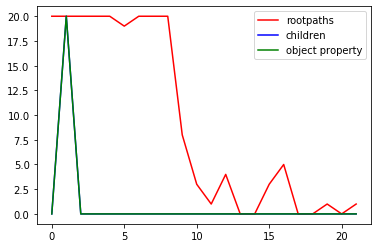

In [111]:
import matplotlib.pyplot as plt
limit = 22
x = list(range(limit))
up_limit = 20
plt.plot(x, [el if el < up_limit else up_limit for el in a_idx[:limit]], 'r') # plotting t, a separately 
plt.plot(x, [el if el < up_limit else up_limit for el in b_idx[:limit]], 'b') # plotting t, b separately 
plt.plot(x, [el if el < up_limit else up_limit for el in c_idx[:limit]], 'g') # plotting t, c separately 
plt.legend(["rootpaths", "children", "object property"])
plt.show()

In [114]:
sorted(Counter(flatten([flatten([[len(path) for path in nbr_type] for nbr_type in elem]) for elem in neighbours_dicts.values()])).items())

[(0, 13571),
 (1, 2541),
 (2, 1303),
 (3, 1143),
 (4, 1405),
 (5, 1752),
 (6, 1842),
 (7, 1573),
 (8, 985),
 (9, 378),
 (10, 153),
 (11, 51),
 (12, 36),
 (13, 14),
 (14, 9),
 (15, 5),
 (16, 3),
 (17, 6),
 (18, 3),
 (19, 5),
 (20, 2),
 (21, 2),
 (22, 3),
 (23, 3),
 (24, 2),
 (25, 3),
 (26, 2),
 (29, 3),
 (30, 1),
 (31, 2),
 (37, 1),
 (38, 1),
 (39, 2),
 (42, 1),
 (43, 1),
 (46, 1),
 (48, 1),
 (59, 1),
 (60, 1),
 (72, 1),
 (75, 1),
 (82, 1),
 (94, 1),
 (106, 1),
 (123, 1),
 (127, 1),
 (129, 1),
 (151, 1)]

In [112]:

[(i,sum(x)) for i,x in enumerate(zip(*[a_idx, b_idx, c_idx])) if sum(x)]


[(0, 1051),
 (1, 15451),
 (2, 641),
 (3, 531),
 (4, 191),
 (5, 19),
 (6, 130),
 (7, 26),
 (8, 39),
 (9, 8),
 (10, 3),
 (11, 1),
 (12, 4),
 (15, 3),
 (16, 5),
 (19, 1),
 (21, 1)]

In [119]:
java_command = 'grep "Final Results" Results/Output*'
process = subprocess.Popen(java_command.split(), stdout=subprocess.PIPE)
output, error = process.communicate()
output

b''

In [10]:
# AML test
train_data, test_data = pickle.load(open("data_anatomy_bert.pkl", "rb"))[:2]
ontologies_in_alignment = [["../Anatomy/Ontologies/mouse.owl", "../Anatomy/Ontologies/human.owl"]]
test_data_t = [key for key in test_data if test_data[key]]
results = []
# all_ont_pairs = list(set([tuple([el.split("#")[0] for el in l]) for l in data.keys()]))
# for i in list(range(0, len(all_ont_pairs), 3)):
#     test_onto = all_ont_pairs[i:i+3]
for ont_pair in ontologies_in_alignment:
    a, b, c = ont_pair[0], ont_pair[1], ont_pair[0].split("/")[-1].split(".")[0] + "-" + ont_pair[1].split("/")[-1].split(".")[0]
    java_command = "java -jar AML_v3.1/AgreementMakerLight.jar -s " + a + " -t " + b + " -o AML-test-results/" + c + ".rdf -a"
    process = subprocess.Popen(java_command.split(), stdout=subprocess.PIPE)
    output, error = process.communicate()
print (os.listdir("AML-test-results/"))
pred_aml = load_alignments("AML-test-results/")

pred_aml_filt = []

for (ont1_name, ont2_name) in ontologies_in_alignment:
    ont1 = Ontology(ont1_name)
    ont2 = Ontology(ont2_name)
    for elem in pred_aml:
        pre1, pre2 = elem[0].split("#")[0].split(".")[0].split("/")[-1], elem[1].split("#")[0].split(".")[0].split("/")[-1]
        elem1, elem2 = elem[0].split("#")[-1], elem[1].split("#")[-1]
        pred_aml_filt.append(( pre1 + "#" + ont1.mapping_dict[elem1], pre2 + "#" + ont2.mapping_dict[elem2]))



# pred_aml_filt = [tuple([el.split("/")[-1] for el in key]) for key in pred_aml_filt]
tp = [elem for elem in pred_aml_filt if elem in test_data and test_data[elem]]
fn = [key for key in test_data_t if key not in set(pred_aml_filt)]
fp = [elem for elem in pred_aml_filt if elem in test_data and not test_data[elem]]


tp_len, fn_len, fp_len = len(tp), len(fn), len(fp)
precision = tp_len/(tp_len+fp_len)
recall = tp_len/(tp_len+fn_len)
f1score = 2 * precision * recall / (precision + recall)
f2score = 5 * precision * recall / (4 * precision + recall)
f0_5score = 1.25 * precision * recall / (0.25 * precision + recall)
print (precision, recall, f1score, f2score, f0_5score)

metrics = [precision, recall, f1score, f2score, f0_5score]
results.append(metrics)

_ = [os.remove(f) for f in glob.glob('AML-test-results/*')]
    
print ("Final Results:", np.mean(results, axis=0))

['mouse-human.rdf']
1.0 0.9013157894736842 0.9480968858131489 0.9194630872483223 0.9785714285714288
Final Results: [1.         0.90131579 0.94809689 0.91946309 0.97857143]


In [21]:
max_pathlen

13

In [ ]:
[elem for elem in pred_aml_filt if "#" not in elem[0] or "#" not in elem[1]]

In [ ]:
f = open("data_unhas.pkl", "wb")
pickle.dump([data, emb_indexer, emb_indexer_inv, emb_vals, gt_mappings, neighbours_dicts, ontologies_in_alignment], f)


In [ ]:
def count_non_unk(elem):
    return len([l for l in elem if l!="<UNK>"])
neighbours_dicts = {ont: {el: neighbours_dicts[ont][el][:int(sys.argv[1])] for el in neighbours_dicts[ont]
       if count_non_unk(neighbours_dicts[ont][el]) > int(sys.argv[2])} for ont in neighbours_dicts}

In [8]:
len(data), len(all_mappings)

(9066182, 9066182)

In [46]:
train_data_t = [key for key in train_data if train_data[key]]
excluded_aml = [key for key in test_data_t + train_data_t if key not in set(pred_aml_filt)]

In [ ]:
import requests

url = "https://montanaflynn-spellcheck.p.rapidapi.com/check/"

headers = {
    'x-rapidapi-host': "montanaflynn-spellcheck.p.rapidapi.com",
    'x-rapidapi-key': "9965b01207msh06291e57d6f2c55p1a6a16jsn0fb016da4a62"
    }

# inp_spellchecked = []
for concept in inp[731:]:
    querystring = {"text": concept}
    response = requests.request("GET", url, headers=headers, params=querystring).json()
    if response["suggestion"] != concept:
        resolved = str(concept)
        for word in response["corrections"]:
            if not re.search("[A-Z][A-Z]+", concept):
                resolved = resolved.replace(word, response["corrections"][word][0])
        
        inp_spellchecked.append(resolved)
        print (concept, resolved)
    else:
        inp_spellchecked.append(concept)




In [ ]:
querystring = {"text": "technically Organised By"}
response = requests.request("GET", url, headers=headers, params=querystring)
response.json()

In [ ]:
data_train, data_test, emb_indexer, emb_indexer_inv, emb_vals, gt_mappings, neighbours_dicts, ontologies_in_alignment = pickle.load(open("data_anatomy_sent2vec.pkl", "rb"))

In [ ]:
# fn_spellchecked, fp_spellchecked = [dict(el) for el in pickle.load(open("test_v2.pkl", "rb"))]
# fn_baseline, fp_baseline = [dict(el) for el in pickle.load(open("test_best.pkl", "rb"))]
# fn_unhas, fp_unhas = [dict(el) for el in pickle.load(open("test_unhas.pkl", "rb"))]
# fn_resolved, fp_resolved = [dict(el) for el in pickle.load(open("test_resolved.pkl", "rb"))]

fn_dict, fp_dict = {}, {}
def create_comparison_file(file, idx):
    fn, fp = [dict(el) for el in pickle.load(open(file, "rb"))]
    
    for key in fn:
        if key in fn_dict:
            fn_dict[key][idx] = fn[key]
        else:
            fn_dict[key] = ["N/A" for i in range(2)]
            fn_dict[key][idx] = fn[key]
    
    for key in fp:
        if key in fp_dict:
            fp_dict[key][idx] = fp[key]
        else:
            fp_dict[key] = ["N/A" for i in range(2)]
            fp_dict[key][idx] = fp[key]
    

create_comparison_file("test_best.pkl", 0)
create_comparison_file("test_unhas.pkl", 1)

open("fn - comparison.tsv", "w+").write("\n".join(["\t".join([str(el) for el in flatten(el)]) for el in fn_dict.items()]))
open("fp - comparison.tsv", "w+").write("\n".join(["\t".join([str(el) for el in flatten(el)]) for el in fp_dict.items()]))

In [43]:
fn_spellchecked, fp_spellchecked = [dict(el) for el in pickle.load(open("test_anatomy_use28_1.pkl", "rb"))]

In [44]:
fn_spellchecked

{('mouse#cerebellar layer',
  'human#Cortical_Cell_Layer_of_the_Cerebellum'): 0.8012549559910933,
 ('mouse#vertebra dorsal arch',
  'human#Arch_of_the_Vertebra'): 0.8190866110128275,
 ('mouse#iliopsoas', 'human#Iliopsoas_Muscle'): 0.7605249355878596,
 ('mouse#retina inner nuclear layer',
  'human#Inner_Nuclear_Layer'): 0.8656842872069336,
 ('mouse#stomach greater curvature',
  'human#Greater_Curvature'): 0.7226314051381755,
 ('mouse#corpora quadrigemina',
  'human#Quadrigeminal_Body'): 0.45310238770181666,
 ('mouse#palatine gland', 'human#Palatine_Salivary_Gland'): 0.8566996196072939,
 ('mouse#lunate', 'human#Lunate_Bone'): 0.7091920887814754,
 ('mouse#crypt of lieberkuhn',
  'human#Crypts_of_the_Lieberkuhn'): 0.7354369438482792,
 ('mouse#kidney interstitium',
  'human#Renal_Interstitial_Tissue'): 0.8072747064853303,
 ('mouse#arrector pili smooth muscle',
  'human#Erector_Muscle_of_the_Hair'): 0.7417348746968164,
 ('mouse#tooth substance', 'human#Tooth_Tissue'): 0.8003664647008165,
 ('

In [ ]:
abbreviations_dict = {}
final_dict = {}

for mapping in all_mappings:
    mapping = tuple([el.split("#")[1] for el in mapping])
    is_abb = re.search("[A-Z][A-Z]+", mapping[0])
    if is_abb:
        abbreviation = "".join([el[0].upper() for el in mapping[1].split("_")])
        if is_abb.group() in abbreviation:
            
            start = abbreviation.find(is_abb.group())
            end = start + len(is_abb.group())
            fullform = "_".join(mapping[1].split("_")[start:end])
            print ("left", mapping, abbreviation, fullform)
            
            rest_first = " ".join([el for el in mapping[0].replace(is_abb.group(), "").split("_") if el]).lower()
            rest_second = " ".join(mapping[1].split("_")[:start] + mapping[1].split("_")[end:])
            if is_abb.group() not in final_dict:
                final_dict[is_abb.group()] = [(fullform, rest_first, rest_second)]
            else:
                final_dict[is_abb.group()].append((fullform, rest_first, rest_second))

    is_abb = re.search("[A-Z][A-Z]+", mapping[1])
    if is_abb:
        abbreviation = "".join([el[0].upper() for el in mapping[0].split("_")])
        
        if is_abb.group() in abbreviation:
            start = abbreviation.find(is_abb.group())
            end = start + len(is_abb.group())
            fullform = "_".join(mapping[0].split("_")[start:end])
            print ("right", mapping, abbreviation, fullform)

            rest_first = " ".join([el for el in mapping[1].replace(is_abb.group(), "").split("_") if el]).lower()
            rest_second = " ".join(mapping[0].split("_")[:start] + mapping[0].split("_")[end:])
            if is_abb.group() not in final_dict:
                final_dict[is_abb.group()] = [(fullform, rest_first, rest_second)]
            else:
                final_dict[is_abb.group()].append((fullform, rest_first, rest_second))

keys = [el for el in list(set(flatten([flatten([tup[1:] for tup in final_dict[key]]) for key in final_dict]))) if el]
abb_embeds = dict(zip(keys, extractUSEEmbeddings(keys)))

scored_dict = {}
for abbr in final_dict:
    sim_list = [(tup[0], tup[1], tup[2], cos_sim(abb_embeds[tup[1]], abb_embeds[tup[2]])) if tup[1] and tup[2]
                else (tup[0], tup[1], tup[2], 0) for tup in final_dict[abbr]]
    scored_dict[abbr] = sorted(list(set(sim_list)), key=lambda x:x[-1], reverse=True)

resolved_dict = {key: scored_dict[key][0] for key in scored_dict}
filtered_dict = {key: " ".join(resolved_dict[key][0].split("_")) for key in resolved_dict if resolved_dict[key][-1] > 0.9}
inp_resolved = []
for concept in inp:
    for key in filtered_dict:
        concept = concept.replace(key, filtered_dict[key])
    inp_resolved.append(concept)
inp_resolved

In [ ]:
keys = [el for el in list(set(flatten([flatten([tup[1:] for tup in final_dict[key]]) for key in final_dict]))) if el]
abb_embeds = dict(zip(keys, extractUSEEmbeddings(keys)))


In [ ]:
reference_alignments

In [ ]:
len([key for key in data_train if data_train[key]]), len([key for key in data_test if data_test[key]])

In [ ]:
scored_dict = {}
for abbr in final_dict:
    sim_list = [(tup[0], tup[1], tup[2], cos_sim(abb_embeds[tup[1]], abb_embeds[tup[2]])) if tup[1] and tup[2]
                else (tup[0], tup[1], tup[2], 0) for tup in final_dict[abbr]]
    scored_dict[abbr] = sorted(list(set(sim_list)), key=lambda x:x[-1], reverse=True)


In [ ]:
inp_case_handled = []
for concept in inp:
    final_list = []
    for word in concept.split(" "):
        if not re.search("[A-Z][A-Z]+", concept):
            final_list.append(word.lower())
        else:
            final_list.append(word)
    case_resolved = " ".join(final_list)
    inp_case_handled.append(case_resolved)
    
inp_case_handled

In [ ]:
Ontology("conference_ontologies/conference.owl").triples

In [ ]:
from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

model = AutoModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

In [ ]:
# from transformers import XLNetTokenizer, XLNetModel
# import torch
# import scipy
# import torch.nn as nn
# import torch.nn.functional as F

tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
model = AutoModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

input_ids = torch.tensor(tokenizer.encode("fastigial nucleus", add_special_tokens=True)).unsqueeze(0)
outputs = model(input_ids)
last_hidden_states = outputs[0].mean(1)

input_ids = torch.tensor(tokenizer.encode("femur", add_special_tokens=True)).unsqueeze(0) 

outputs1 = model(input_ids)
last_hidden_states1 = outputs1[0].mean(1)

cos = nn.CosineSimilarity(dim=1, eps=1e-6)
cos(last_hidden_states, last_hidden_states1)

In [28]:
# model_path = "/home/vlead/BioSentVec_PubMed_MIMICIII-bigram_d700.bin"
# model = sent2vec.Sent2vecModel()
# try:
#     model.load_model(model_path)
# except Exception as e:
#     print(e)
# print('model successfully loaded')

stop_words = set(stopwords.words('english'))
def preprocess_sentence(text):
    text = text.replace('/', ' / ')
    text = text.replace('.-', ' .- ')
    text = text.replace('.', ' . ')
    text = text.replace('\'', ' \' ')
    text = text.lower()

    tokens = [token for token in word_tokenize(text) if token not in punctuation and token not in stop_words]

    return ' '.join(tokens)

def extract_huggingface_embeddings(words):
    return model.embed_sentences([preprocess_sentence(elem) for elem in words])


cos_sim(*extractUSEEmbeddings(["adrenal gland zona reticularis", "Reticularis Zone"])), cos_sim(*extract_huggingface_embeddings(["adrenal gland zona reticularis", "Reticularis Zone"]))

0.35638532042503357

In [22]:
def extractUSEEmbeddings(words):
    try:
        embed = hub.KerasLayer(USE_folder)
    except Exception as e:
        !mkdir $USE_folder
        !curl -L "https://tfhub.dev/google/universal-sentence-encoder-large/5?tf-hub-format=compressed" | tar -zxvC $USE_folder
        embed = hub.KerasLayer(USE_folder)
        pass
    word_embeddings = embed(words)
    return word_embeddings.numpy()

In [51]:
use, bio2vec = 0, 0
final_list = []
for pair in fn_spellchecked:
    pair_proc = [" ".join(parse(el.split("#")[1])).lower() for el in pair]
    use_score = cos_sim(embeddings[pair[0]], embeddings[pair[1]])
    bio2vec_score = cos_sim(*extract_huggingface_embeddings(list(pair_proc)))
    use += use_score
    bio2vec += bio2vec_score
    final_list.append([pair[0], pair[1], fn_spellchecked[pair], use_score, bio2vec_score, pair in excluded_aml, ""])
open("results_anatomy_use_fn.tsv", "w+").write("\n".join(["\t".join([str(col) for col in entry]) for entry in final_list]))
print ("Total", use, bio2vec)

Total 17.165284897635363 17.700582340359688


In [52]:
use, bio2vec = 0, 0
final_list = []
for pair in fp_spellchecked:
    pair_proc = [" ".join(parse(el.split("#")[1])).lower() for el in pair]
    use_score = cos_sim(embeddings[pair[0]], embeddings[pair[1]])
    bio2vec_score = cos_sim(*extract_huggingface_embeddings(list(pair_proc)))
    use += use_score
    bio2vec += bio2vec_score
    final_list.append([pair[0], pair[1], fp_spellchecked[pair], use_score, bio2vec_score, pair in excluded_aml, ""])
open("results_anatomy_use_fp.tsv", "w+").write("\n".join(["\t".join([str(col) for col in entry]) for entry in final_list]))
print ("Total", use, bio2vec)

Total 12.82707794533874 11.156346499919891
